In [1]:
import os
from collections import Counter
import nltk
import gensim  #for topic modelling
from bs4 import BeautifulSoup #for extracting text 
import nltk # for text preprocessing
import re 
import pandas as pd
import numpy as np
import sys
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import string
from sklearn.decomposition import NMF
import matplotlib 
import matplotlib.pyplot as plt
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
matplotlib.rcParams['figure.figsize'] = (20,10)

import warnings
warnings.filterwarnings('ignore')

### read data

In [2]:
path = './inaugural_speeches/'
files = [path + fname for fname in os.listdir(path)]
files[0]

'./inaugural_speeches/37_roosevelt_franklin_1933.txt'

In [3]:
data = []
for fname in files:
    with open(fname, 'r') as f:
        lines = ' '.join(f.readlines())
        data.append(lines)

In [4]:
stoplist = set([u'state', u'country', u'nation', u'people', u'constitution',u'duty', u'government', u'citizen', u'law', u'right', u'union',u'power', u'year', u'world', u'interest', u'purpose', u'justice',u'principle', u'it', u'time', u'question', u'executive', u'war',u'peace', u'life', u'institution', u'condition', u'effort', u'land',u'faith', u'place', u'office', u'today', u'thing', u'opinion',u'home', u'action', u'god', u'cause', u'century', u'strength', u'danger', u'revenue',u'subject',u'republic', 'ha', 'man', 'men', 'day', 'hope', 'u'])
#stoplist = set([u'state', u'country', u'nation', u'people', u'constitution',u'duty', u'government', u'citizen'])

###  remove stopwords, punctuation, pos tag

In [5]:
stop = set(stopwords.words('english'))
stop.update(stoplist)
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    punc_free = ''.join(ch for ch in doc if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    doc_filter = " ".join([word for word, pos in nltk.pos_tag(normalized.lower().split()) if pos=='NN' ])
    stop_free = [i for i in doc_filter.split() if i not in stop]

    doc_count = pd.Series(stop_free).value_counts()
    doc_count = set(doc_count[doc_count==1].index.values)
    new_words = ' '.join([w for w in stop_free if w not in doc_count])
    
    return new_words

In [6]:
doc_clean = [clean(doc).split() for doc in data]

### pos distribution

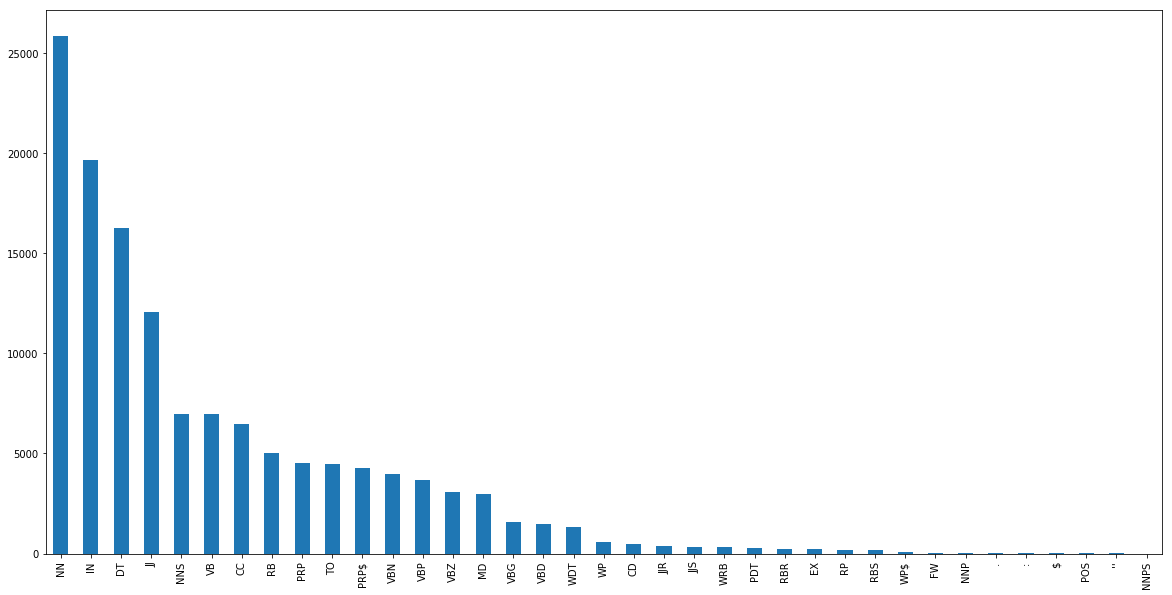

In [7]:
pos = [pos for doc in data for word, pos in nltk.pos_tag(doc.lower().split())]
pos = pd.Series(pos)
pos.value_counts().head(50).plot.bar()

### word distribution

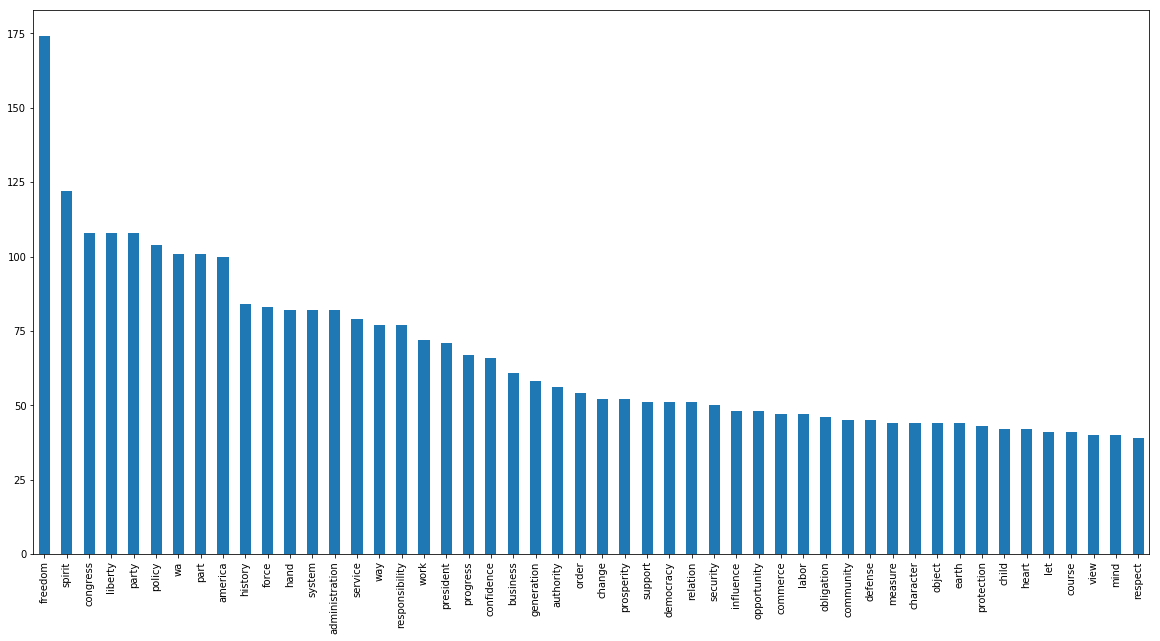

In [8]:
all_tokens = [x for y in doc_clean for x in y]
all_tokens = pd.Series(all_tokens)
all_tokens.value_counts().head(50).plot.bar()

In [9]:
all_tokens.value_counts().head(50).index.values

array(['freedom', 'spirit', 'congress', 'liberty', 'party', 'policy', 'wa',
       'part', 'america', 'history', 'force', 'hand', 'system',
       'administration', 'service', 'way', 'responsibility', 'work',
       'president', 'progress', 'confidence', 'business', 'generation',
       'authority', 'order', 'change', 'prosperity', 'support',
       'democracy', 'relation', 'security', 'influence', 'opportunity',
       'commerce', 'labor', 'obligation', 'community', 'defense',
       'measure', 'character', 'object', 'earth', 'protection', 'child',
       'heart', 'let', 'course', 'view', 'mind', 'respect'], dtype=object)

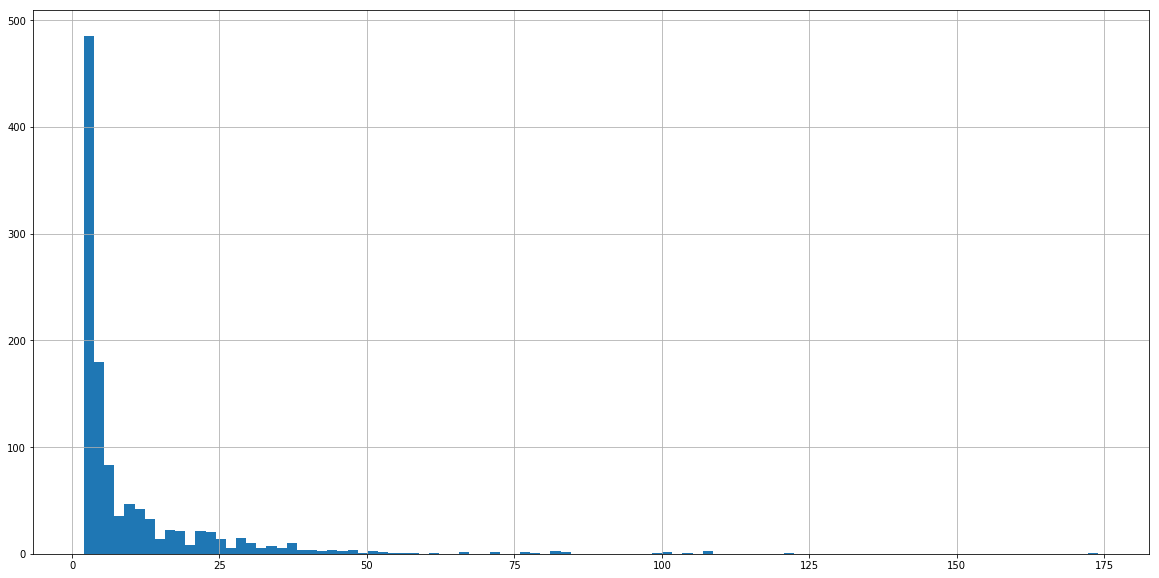

In [10]:
all_tokens.value_counts().hist(bins=100)

### plot theme of some transcripts

(-0.5, 399.5, 199.5, -0.5)

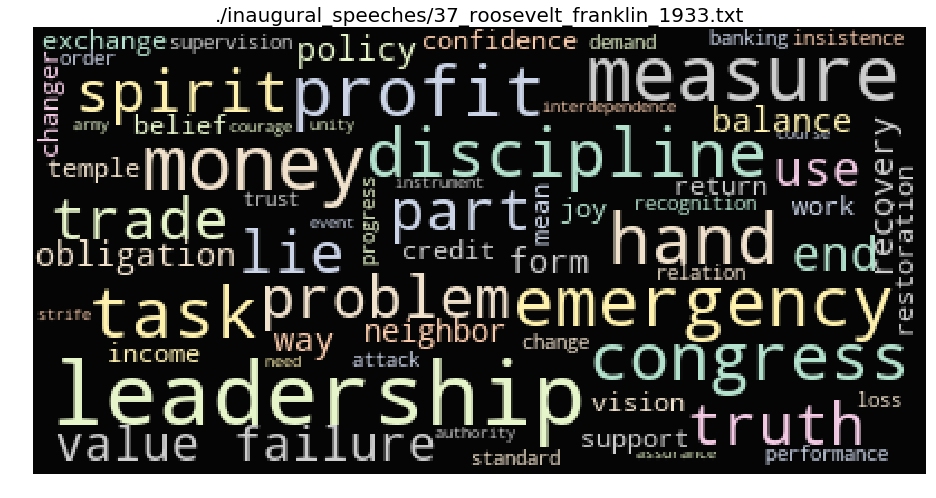

In [11]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(doc_clean[0]))
plt.title(files[0], fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

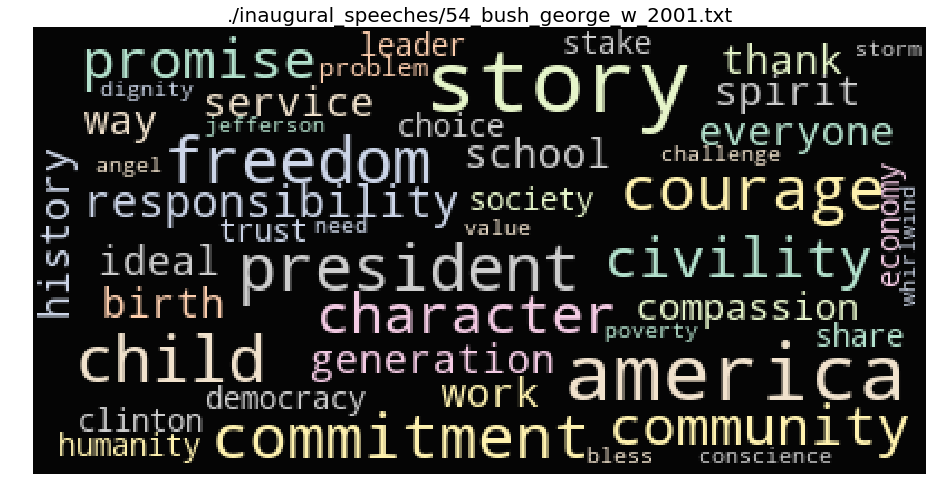

In [12]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(doc_clean[1]))
plt.title(files[1], fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

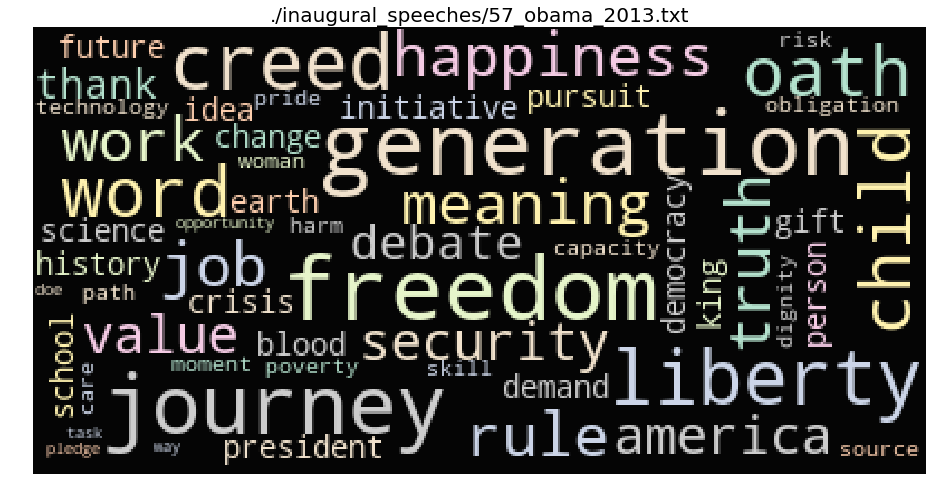

In [13]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(doc_clean[23]))
plt.title(files[23], fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

In [14]:
word_counts = pd.Series(np.concatenate(doc_clean)).value_counts()
singular_words = set(word_counts[pd.Series(np.concatenate(doc_clean)).value_counts() <= 2].index)

In [15]:
len(singular_words)

407

In [16]:
doc_stemmed = [[word for word in title if word not in singular_words] for title in doc_clean]

In [17]:
non_empty_indices = [i for i in range(len(doc_stemmed)) if len(doc_stemmed[i]) > 0]
doc_stemmed = np.asarray(doc_stemmed)[non_empty_indices]

In [18]:
dictionary = gensim.corpora.Dictionary(doc_stemmed)

In [19]:
corpus = [dictionary.doc2bow(text) for text in doc_stemmed]


In [20]:
model =  gensim.models.ldamodel.LdaModel
ldamodel = model(corpus, num_topics=20, id2word = dictionary, passes=200)

In [22]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
10     15.727985        1       1  0.119117  0.038770
1      11.921898        1       2  0.038940  0.008405
5      11.757355        1       3  0.111152 -0.087899
13      7.807053        1       4  0.069347  0.076734
16      6.916908        1       5  0.140956  0.175823
3       6.449953        1       6 -0.235586 -0.056472
0       5.938285        1       7 -0.151735  0.031398
11      5.471769        1       8 -0.212804 -0.014005
18      4.250041        1       9  0.104551 -0.070822
19      3.825768        1      10 -0.160847 -0.021140
2       3.509831        1      11 -0.232859 -0.049402
6       3.438549        1      12 -0.105879  0.069506
4       2.967888        1      13  0.139235 -0.154810
7       2.641460        1      14  0.074397 -0.150256
9       2.520070        1      15  0.115571 -0.188427
12      1.575310        1      16  0.021755  0.053290
15      1.455421        1      17  0.025727  0.064215
17      1.187981        1      18  0.074217  0.126533
8       0.434940        1      19  0.080433  0.080088
14      0.201536        1      20 -0.015687  0.068469, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
56    Default   70.000000             way   70.000000  30.0000  30.0000
74    Default  164.000000         freedom  164.000000  29.0000  29.0000
33    Default   95.000000            part   95.000000  28.0000  28.0000
9     Default  103.000000        congress  103.000000  27.0000  27.0000
35    Default   98.000000          policy   98.000000  26.0000  26.0000
58    Default   94.000000         america   94.000000  25.0000  25.0000
70    Default   47.000000       democracy   47.000000  24.0000  24.0000
113   Default   39.000000           heart   39.000000  23.0000  23.0000
125   Default  102.000000         liberty  102.000000  22.0000  22.0000
84    Default   72.000000  responsibility   72.000000  21.0000  21.0000
8     Default   61.000000      confidence   61.000000  20.0000  20.0000
190   Default   30.000000            oath   30.000000  19.0000  19.0000
129   Default  104.000000           party  104.000000  18.0000  18.0000
86    Default   74.000000         service   74.000000  17.0000  17.0000
287   Default   30.000000          friend   30.000000  16.0000  16.0000
387   Default   19.000000            debt   19.000000  15.0000  15.0000
429   Default   58.000000        business   58.000000  14.0000  14.0000
20    Default   77.000000            hand   77.000000  13.0000  13.0000
152   Default   79.000000           force   79.000000  12.0000  12.0000
32    Default   51.000000           order   51.000000  11.0000  11.0000
230   Default   34.000000      countryman   34.000000  10.0000  10.0000
44    Default  115.000000          spirit  115.000000   9.0000   9.0000
57    Default   68.000000            work   68.000000   8.0000   8.0000
158   Default   17.000000              mr   17.000000   7.0000   7.0000
75    Default   55.000000      generation   55.000000   6.0000   6.0000
51    Default   19.000000           truth   19.000000   5.0000   5.0000
28    Default   29.000000           money   29.000000   4.0000   4.0000
31    Default   43.000000      obligation   43.000000   3.0000   3.0000
108   Default   35.000000         example   35.000000   2.0000   2.0000
181   Default   26.000000          method   26.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
710   Topic20    0.019373       precedent    3.649919   0.9684  -7.0282
709   Topic20    0.019373        contract    3.649919   0.9684  -7.0282
700   Topic20    0.019373        mountain    3.695060   0.9561  -7.0282
503   Topic20    0.019373          debate    3.695060   0.9561  -7.0282
699   Topic20    0.019373      dedication    3.695060   0.9561  -7.0282
701   Topic20    0.019373      de

In [23]:
doc = [clean(doc) for doc in data]
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.95, min_df=2)
wordvector_fit = wordvector.fit_transform(doc)
feature = wordvector.get_feature_names()

In [24]:
nmf = NMF(n_components=20, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(wordvector_fit.todense())

In [32]:
np.sum(np.square(wordvector_fit.todense()[23] - nmf.components_), axis=1)

matrix([[ 1.50403517],
        [ 0.70843279],
        [ 1.40681405],
        [ 1.07986904],
        [ 1.34027172],
        [ 1.13461295],
        [ 1.22222754],
        [ 1.68947826],
        [ 1.47857452],
        [ 1.3294337 ],
        [ 1.20045765],
        [ 1.35423396],
        [ 1.2990063 ],
        [ 1.18355614],
        [ 1.36110161],
        [ 1.35095649],
        [ 1.72029291],
        [ 1.42951397],
        [ 1.27909826],
        [ 1.32920555]])

In [26]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
display_topics(nmf, feature, 10)        

Topic 0:
object circumstance authority confidence party happiness commerce administration wa limit
Topic 1:
freedom america generation president history word dream child work moment
Topic 2:
congress business policy order progress legislation trade party race tariff
Topic 3:
covenant change generation stranger enemy liberty child way moment promise
Topic 4:
responsibility let america promise era challenge policy structure retreat end
Topic 5:
freedom force earth fate equality help island change le communism
Topic 6:
party contest respect member fact reform race dispute appointment public
Topic 7:
oath zeal end enterprise enjoyment engagement enforcement energy enemy endeavor
Topic 8:
thought counsel influence opportunity task consciousness process consent sea spirit
Topic 9:
militia accountability improvement branch aid officer service money independence importance
Topic 10:
democracy america spirit body freedom person task destiny peril measure
Topic 11:
measure purity care continuanc

In [27]:
N = 20
clf = KMeans(n_clusters=N,
            max_iter=100,
            init='k-means++',
            n_init=1)
labels = clf.fit_predict(wordvector_fit)

In [28]:
wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

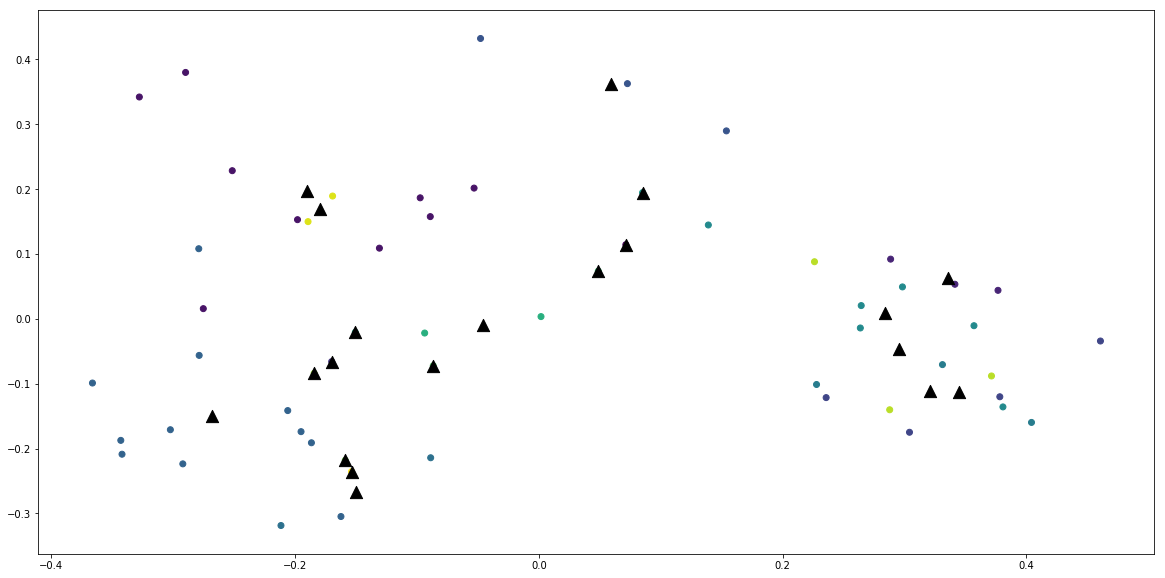

In [29]:

plt.scatter(datapoint[:, 0], datapoint[:, 1], c=labels)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [33]:
ldamodel[corpus[23]]

[(11, 0.99316549)]

In [34]:
ldamodel.print_topic(11)

'0.055*"freedom" + 0.029*"generation" + 0.022*"force" + 0.020*"work" + 0.019*"history" + 0.017*"earth" + 0.017*"america" + 0.016*"child" + 0.014*"way" + 0.014*"friend"'

In [35]:
hdpmodel = gensim.models.HdpModel(corpus, id2word=dictionary)

In [36]:
pyLDAvis.gensim.prepare(hdpmodel, corpus, dictionary)

PreparedData(topic_coordinates=               Freq  cluster  topics         x         y
topic                                                   
0      9.271371e+00        1       1 -0.036586 -0.008340
1      8.623196e+00        1       2 -0.040915 -0.020456
2      6.231712e+00        1       3 -0.018877 -0.013270
3      5.862291e+00        1       4 -0.026786  0.023776
7      4.889087e+00        1       5 -0.013556  0.006167
4      4.285817e+00        1       6 -0.005483 -0.004452
9      4.218285e+00        1       7 -0.020928 -0.014272
8      4.043121e+00        1       8 -0.006983 -0.030328
11     3.478652e+00        1       9 -0.037304  0.010873
14     3.365966e+00        1      10 -0.018370  0.002292
5      3.363817e+00        1      11 -0.016826 -0.014668
12     3.169115e+00        1      12  0.001836  0.058141
50     2.702262e+00        1      13 -0.015665  0.000788
15     2.157920e+00        1      14 -0.014963 -0.009982
13     2.153188e+00        1      15 -0.001679 -0.008152
18     2.093749e+00        1      16 -0.002761  0.023096
16     2.040762e+00        1      17  0.003022 -0.003013
22     1.937669e+00        1      18 -0.048786  0.006434
10     1.852875e+00        1      19  0.002345  0.008385
37     1.780435e+00        1      20 -0.028178 -0.004027
31     1.725888e+00        1      21 -0.017321  0.031245
34     1.688520e+00        1      22  0.021059 -0.021809
47     1.512606e+00        1      23 -0.011214 -0.013145
19     1.436514e+00        1      24 -0.006615 -0.033602
17     1.366702e+00        1      25 -0.006728 -0.000840
67     1.355783e+00        1      26 -0.026088  0.011399
57     1.235892e+00        1      27  0.011560  0.013526
6      1.201217e+00        1      28 -0.041318  0.017458
33     1.135332e+00        1      29  0.019518  0.027058
44     1.106886e+00        1      30 -0.011119 -0.017466
...             ...      ...     ...       ...       ...
116    2.673867e-16        1     121  0.007947 -0.005174
117    1.721708e-16        1     122  0.015082  0.032801
118    1.112732e-16        1     123  0.009361  0.007730
120    4.196340e-17        1     124  0.020462 -0.028238
121    2.519361e-17        1     125 -0.019459 -0.002253
123    9.104359e-18        1     126 -0.004625 -0.011496
124    5.473359e-18        1     127 -0.011668  0.029296
125    3.283684e-18        1     128 -0.015004 -0.008812
126    1.970929e-18        1     129  0.023082 -0.005144
128    6.583191e-19        1     130  0.015298  0.017103
129    3.670868e-19        1     131 -0.001653 -0.011175
130    2.038454e-19        1     132 -0.004853 -0.025924
131    1.131411e-19        1     133  0.001208  0.024278
132    6.272163e-20        1     134  0.007590 -0.002123
133    3.478755e-20        1     135  0.020466  0.008407
134    1.935916e-20        1     136 -0.002370  0.005888
135    1.073468e-20        1     137  0.007764  0.020144
136    5.880636e-21        1     138  0.035266  0.002528
137    3.260645e-21        1     139 -0.007383  0.018330
138    1.781106e-21        1     140  0.013177 -0.009736
140    5.008324e-22        1     141  0.017183  0.001942
141    2.568081e-22        1     142 -0.001553  0.013712
142    1.308118e-22        1     143 -0.010233 -0.014189
143    6.675844e-23        1     144  0.003301 -0.006580
144    3.413341e-23        1     145 -0.001418  0.023693
145    1.745563e-23        1     146 -0.006727 -0.032213
146    8.635609e-24        1     147  0.032871 -0.020998
147    4.343856e-24        1     148 -0.018328  0.011523
148    2.182879e-24        1     149 -0.004366 -0.007245
149    2.175234e-24        1     150 -0.007504 -0.017905

[150 rows x 5 columns], topic_info=      Category          Freq            Term      Total  loglift  logprob
term                                                                     
152    Default  3.400000e+01           force  34.000000  30.0000  30.0000
74     Default  3.300000e+01         freedom  33.000000  29.0000  29.0000
38     Default  3.200000e+01        progress  

In [37]:
hdpmodel[corpus[23]]

[(3, 0.17804832833092987), (75, 0.81549544662281903)]

In [ ]:
hdpmodel.get_topics()